<div style="color:white;background-color:#00A67E;padding:3%;border-radius:150px 150px;font-size:2em;text-align:center">
    <font color="White" size=+4 face="Arial Black">Twitter Hate Speech</font><br><font color="White" size=+2 face="Lucida Calligraphy">(Sentiments, Topics, Modeling)</font>
</div>

# Importing Packages

In [3]:
# General packages
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Text Processing and preprocessing
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk import FreqDist
from wordcloud import WordCloud

# Sentiment Analysis Packages
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Topic Modeling
from gensim import corpora, models

# Options
pd.options.display.max_columns = None
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Loading Dataset

In [4]:
df = pd.read_csv(r'/kaggle/input/twitter-hate-speech/train_E6oV3lV.csv', low_memory = False)
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# Data Understanding

In [5]:
# Statistical Distribution of the the Numerical variables in the tweets dataset
print(df.shape)
df.describe()

(31962, 3)


,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [6]:
# A summary of the overall dataset
def summary(df):
    summary = pd.DataFrame(df.dtypes, columns = ['dtypes'])
    summary = summary.reset_index()
    summary['missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    return summary

summary(df)

,index,dtypes,missing,Uniques
0,id,int64,0,31962
1,label,int64,0,2
2,tweet,object,0,29530


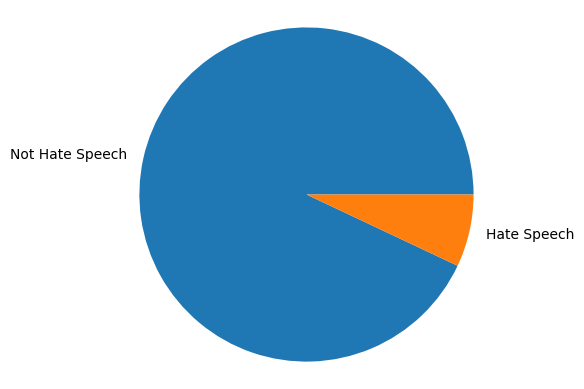

In [7]:
plt.pie(df.label.value_counts(), labels = ['Not Hate Speech', 'Hate Speech'])
plt.axis('equal')
plt.show()

# Data Preprocessing

### Sentence Tokenizing

In [9]:
nltk.download('punkt')

sent_tokenized = []

for text in df['tweet'].values:
    tokens = nltk.sent_tokenize(text)
    sent_tokenized.append(tokens)

df['Sentence Tokenized'] = sent_tokenized
df.head()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,label,tweet,Sentence Tokenized
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...
2,3,0,bihday your majesty,[ bihday your majesty]
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation]


### Word Tokenizing

In [10]:
# For topic modeling we start form the body of tweets to perform word tokenizing.
all_docs = df['tweet'].values

exclude = set(string.punctuation)
tokenized = []
tokenizer = TweetTokenizer()
for doc in all_docs:
    tokens = tokenizer.tokenize(doc.lower())
    tokenized.append(''.join([ch for ch in ' '.join(tokens) if ch not in exclude]).split())

df['Word Tokenized'] = tokenized
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]"


### Removing Punctuations

In [11]:
def remove_punctuation(tokens):
    punctuations = string.punctuation
    tokens = [token.translate(str.maketrans('', '', punctuations)) for token in tokens]
    tokens = [token for token in tokens if len(token) > 1]
    return tokens

df['Punctuation Removed'] = df['Word Tokenized'].apply(remove_punctuation)
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ..."
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


### Removing StopWords and Other Unnecessaries

In [12]:
sw = set(stopwords.words('english'))
sw.add('rt')
sw.add('...')

sw_removed = []
for j, sent in enumerate(df['Word Tokenized']):
    sw_removed.append([i for i in sent
                      if i not in sw
                      and len(i)>2
                      and (not i.startswith("http"))])

df['Stopword Removed'] = sw_removed
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]"
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]"
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]"


### Part of Speech Tagging

In [13]:
pos_tags_list = []
for tokens in df['Word Tokenized']:
    pos_tags = nltk.pos_tag(tokens)
    pos_tags_list.append(pos_tags)
df['pos_tags'] = pos_tags_list
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]"
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (..."
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (..."


### Word Stemming

In [14]:
stemmer = PorterStemmer()
def stemming(words):
    return [stemmer.stem(word) for word in words]

df['Word Stemmed'] = df['Stopword Removed'].apply(stemming)
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d..."
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c..."
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]"
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]"
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]"


### Lemmatization

In [15]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if not token.is_punct and not token.is_space and token.is_alpha:
                if token.pos_ in allowed_postags:
                    new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out

df['Lemmatized Text'] = lemmatization(df['tweet'])

df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed,Lemmatized Text
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d...",father dysfunctional so selfish kid dysfunction
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c...",thank lyft credit wheelchair van getthanked
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]",bihday majesty
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]",model time
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]",factsguide society now motivation


### Word Tokenizing The Lemmatized Column

In [16]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_and_tokenize(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.pos_ in ["NOUN", "ADJ", "ADV"]]
    return tokens

df['Tokenized Lem'] = df['Lemmatized Text'].apply(lemmatize_and_tokenize)
df.head()

,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed,Lemmatized Text,Tokenized Lem
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d...",father dysfunctional so selfish kid dysfunction,"[so, selfish, kid, dysfunction]"
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c...",thank lyft credit wheelchair van getthanked,"[lyft, credit]"
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]",bihday majesty,[]
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]",model time,"[model, time]"
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]",factsguide society now motivation,"[society, now]"


# Feature Engineering
## Adding Sentiments as Features

In [17]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

scores = []
for sentence_list in df['tweet'].apply(nltk.sent_tokenize):
    sentence_scores = []
    for sentence in sentence_list:
        sentence_score = sid.polarity_scores(sentence)
        sentence_scores.append(sentence_score)
    avg_score = {k: sum(d[k] for d in sentence_scores) / len(sentence_scores) for k in sentence_scores[0]}
    scores.append(avg_score)

sentiment_df = pd.DataFrame(scores)
df = pd.concat([df, sentiment_df], axis=1)

df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed,Lemmatized Text,Tokenized Lem,neg,neu,pos,compound
0,1,0,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d...",father dysfunctional so selfish kid dysfunction,"[so, selfish, kid, dysfunction]",0.201,0.799,0.000,-0.41480
1,2,0,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c...",thank lyft credit wheelchair van getthanked,"[lyft, credit]",0.000,0.859,0.141,0.33525
2,3,0,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]",bihday majesty,[],0.000,1.000,0.000,0.00000
3,4,0,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]",model time,"[model, time]",0.000,0.806,0.194,0.36245
4,5,0,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]",factsguide society now motivation,"[society, now]",0.000,1.000,0.000,0.00000


**By reviewing the texts and the scores of VADER technique, it seems that the model did not scored the sentences correctly, we we incorporating other techniques aiming better results**

### Ensemble Sentiment Analysis

### Assigning Sentiment Tags to The Scores

In [18]:
#Labeling the sentiments based on the compound score
def label_sentiment(row):
    cutoff = .33
    if row['compound'] < -1 * cutoff:
        return "neg"
    elif row['compound'] > cutoff:
        return "pos"
    else:
        return "neu"
    
df["label"] = df.apply(label_sentiment, axis=1)

# Sentiment of the whole Small dataset
total_sent_small = np.mean(df['compound'])
print("Sentiment of the whole small dataset: ", total_sent_small)
df.head()

Sentiment of the whole small dataset:  0.09458568033170342


,id,label,tweet,Sentence Tokenized,Word Tokenized,Punctuation Removed,Stopword Removed,pos_tags,Word Stemmed,Lemmatized Text,Tokenized Lem,neg,neu,pos,compound
0,1,neg,@user when a father is dysfunctional and is s...,[ @user when a father is dysfunctional and is ...,"[user, when, a, father, is, dysfunctional, and...","[user, when, father, is, dysfunctional, and, i...","[user, father, dysfunctional, selfish, drags, ...","[(user, NN), (when, WRB), (a, DT), (father, NN...","[user, father, dysfunct, selfish, drag, kid, d...",father dysfunctional so selfish kid dysfunction,"[so, selfish, kid, dysfunction]",0.201,0.799,0.000,-0.41480
1,2,pos,@user @user thanks for #lyft credit i can't us...,[@user @user thanks for #lyft credit i can't u...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, for, lyft, credit, cant, ...","[user, user, thanks, lyft, credit, cant, use, ...","[(user, RB), (user, JJ), (thanks, NNS), (for, ...","[user, user, thank, lyft, credit, cant, use, c...",thank lyft credit wheelchair van getthanked,"[lyft, credit]",0.000,0.859,0.141,0.33525
2,3,neu,bihday your majesty,[ bihday your majesty],"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, majesty]","[(bihday, RB), (your, PRP$), (majesty, NN)]","[bihday, majesti]",bihday majesty,[],0.000,1.000,0.000,0.00000
3,4,pos,#model i love u take with u all the time in ...,[#model i love u take with u all the time in...,"[model, i, love, u, take, with, u, all, the, t...","[model, love, take, with, all, the, time, in, ...","[model, love, take, time, urð]","[(model, NN), (i, NN), (love, VBP), (u, JJ), (...","[model, love, take, time, urð]",model time,"[model, time]",0.000,0.806,0.194,0.36245
4,5,neu,factsguide: society now #motivation,[ factsguide: society now #motivation],"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, motivation]","[(factsguide, JJ), (society, NN), (now, RB), (...","[factsguid, societi, motiv]",factsguide society now motivation,"[society, now]",0.000,1.000,0.000,0.00000


### Statistics of the Sentiments

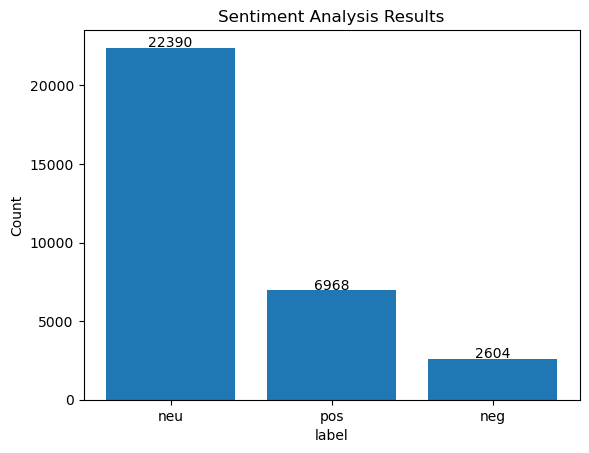

In [19]:
counts = df['label'].value_counts()
plt.bar(counts.index, counts.values)

for i, count in enumerate(counts.values):
    plt.text(i, count+50, str(count), ha='center')

plt.xlabel('label')
plt.ylabel('Count')
plt.title('Sentiment Analysis Results')

plt.show()

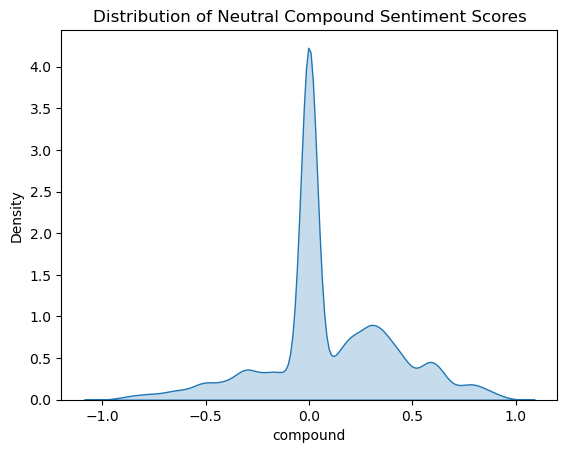

In [21]:
sns.kdeplot(data=df, x='compound', label='compound', fill=True)

plt.title("Distribution of Neutral Compound Sentiment Scores")
plt.show()

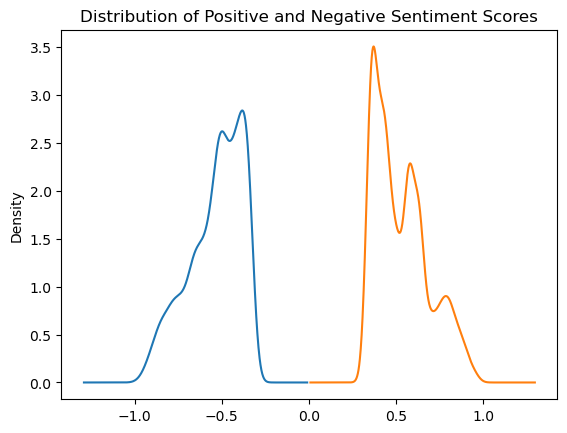

In [22]:
df[df.label=="neg"]['compound'].plot.kde();
df[df.label=="pos"]['compound'].plot.kde();
plt.title("Distribution of Positive and Negative Sentiment Scores")
plt.show()